In [1]:
from numpy import sin,cos,fft,linspace,pi,exp,zeros,ones,genfromtxt,savetxt
import matplotlib.pyplot as plt
from time import time

In [2]:
class Wave_packet_dynamics:
    
    def __init__(self,filename='',memory_freq=1,fileoutput=''):
        
        
        ''' Module calculates how a specific wavepacket evolves in time when subject to a determined potential.
            
            input arguments:
            
            filename=''
            name of the input file where the values of the variables are stored.
            for the order the order in wich the variables are meant to be given, see the module documentataion.
            if no file name is given, standard values are assigend to the variables
            
            memory_freq=1
            number of steps between recordings of the state of the sistem
            
            Module contains functions:
            
            
            norm
            potential
            gaussian
            dynamics
            visualizer
            
            
            
        '''
        
        if filename=='':
            
            #example parameters, given if filename is not specified 
            
            #PARAMETRI_BASE
            
            self.nx=1024
            self.nt=4096
            self.Lung=100.0
            self.tmax=0.12

            #PARAMETRI GAUSSIANA
            self.sigma=2.0
            self.xo=10.0
            self.ko=5.0

            #PARAMETRI BARRIERE DI POTENZIALE
            self.l1=0.4
            self.l2=0.4
            self.E1=1000.0
            self.E2=100.0
            self.x1=self.Lung/3.0
            self.x2=self.Lung/2.0
            
        else:
            
            #Reading parameters from a file
            
            params=genfromtxt(filename)
            print(params)
            
            
            #params=zeros(12)
            self.nx=int(params[0])
            self.nt=int(params[1])
            self.Lung=params[2]
            self.tmax=params[3]

            #PARAMETRI GAUSSIANA
            self.sigma=params[4]
            self.xo=params[5]
            self.ko=params[6]

            #PARAMETRI BARRIERE DI POTENZIALE
            self.l1=params[7]
            self.l2=params[8]
            self.E1=params[9]
            self.E2=params[10]
            
            self.x1=self.Lung*params[11]
            self.x2=self.Lung*params[12]

        
    #Error check    
    
        
        if self.nx!=round(self.nx) or self.nt!=round(self.nt):

            raise ValueError('N. of steps must be an integer')
            
        if self.xo<0 or self.xo>self.Lung:
            
            raise ValueError('Wave packet centered on a point outside of the given domain')        
                    
        if self.x1<0 or self.x1>self.Lung or self.x2<0 or self.x2>self.Lung:
            
            raise ValueError('Potential barrier centered on a point outside of the given domain')        
                
        
        #initialising parameters not given in the file            
        self.i=complex(0,1)
        self.fq=memory_freq
        
        #setting time and space domains
        self.x=linspace(0.,self.Lung,self.nx,endpoint=False)
        self.t=linspace(0.,self.tmax,self.nt)
        
        self.dx=self.x[1]
        self.dt=self.t[1]
        self.dt2=self.dt*0.5
        
        
        
        self.V=zeros(self.nx)
        
        #initializing memory storage arrays
        memory_size=round(self.nt/self.fq)
        
        if (memory_size-self.nt/self.fq)!=0 :
            memory_size+=1
            
        
        self.ystory=zeros((memory_size,self.nx))
        self.normstory=zeros(memory_size)
        self.ystoryimag=zeros((memory_size,self.nx))
        self.ystoryreal=zeros((memory_size,self.nx))
        
        #setting moment domain
        
        kf=fft.fftfreq(self.nx)

        self.k=kf*self.nx*2*pi/self.Lung
        
        #calculating initial wavepacket and potential from the values the program got from the input file
        
        self.gaussian()
        self.potential()
        self.n_output=fileoutput
        
        
    def norm(self,dx,y):

        ''' Function calculates an approximation of the integral of a function with a Rienmann sum
            args:
            dx= length of the steps between values
            y=function values
            '''

        norma=0
        n=len(y)

        for i in range(n):
            norma+= y[i]*dx
            
        return norma
    
        
    
    
    def gaussian(self,params=[float,float,float]):
    
        '''Function creates the initial condition for the wave
        
        gaussian(params[])
        
        the optional argument params must be a list containing the values given to the variables
        sigma, xo and ko, in this order.
        '''
        
        #checks if user has changed any values
        
        if params!=[float,float,float]:
            
            self.sigma=params[0]
            self.xo=params[1]
            self.ko=params[2]
        
    
        sigma2=self.sigma**2
        self.y=(2*pi*sigma2)**(-0.25)*exp(-(self.x-self.xo)**2/(4*sigma2))*exp(self.i*self.ko*self.x)
        

        
        
    def potential(self,params=[float,float,float,float,float,float]):
    
        '''Function creates an array that describes two potential barriers

            potential(params[])

            the optional argument params must be a list containing the values given to the variables
            l1, l2 , E1, E2, x1, x2 in this order.
            
            
            
        '''
        
        self.V=zeros(self.nx)

        #checks if user has changed any values

    
        if params!=[float,float,float,float,float,float]:
            

            self.l1=params[0]
            self.l2=params[1]
            self.E1=params[2]
            self.E2=params[3]
            
            self.x1=params[4]
            self.x2=params[5]            
    
        #Setting the potential array

        l12=self.l1*0.5
        l22=self.l2*0.5

        for i in range(len(self.x)):
            if self.x[i]>=(self.x1-l12) and self.x[i]<=(self.x1+l12):
                self.V[i]=self.E1

            elif self.x[i]>=(self.x2-l22) and self.x[i]<=(self.x2+l22):
                self.V[i]=self.E2
            
            
    def dynamics(self):
        
        '''Calculates the evolution in time of the wavepacket'''
        
        opkine=exp(-self.i*self.dt2*self.k**2*self.Lung) #kinetic operator in k-space
        
        oppotential=exp(-self.i*self.dt2*self.V) #potential operator in x-space
        
        
        #memory storing initial values
        yreal=abs(self.y[:])**2
        
        self.normstory[0]=self.norm(self.dx,yreal) #calcolo della norma
        self.ystory[0,:]=yreal[:]            #registrazione in memoria dei dati
        self.ystoryimag[0,:]=self.y.imag
        self.ystoryreal[0,:]=self.y.real
        
        niter=0
        memory_st=1
        
        #norm check
        
        if self.normstory[0]<0.99 or self.normstory[0]>1.01 :
            
            plt.figure()
            plt.plot(self.x,self.ystory[0,:])
            plt.show()
            
            raise ValueError('The Wavepacket is not normalized, check if it fits in the given domain')
        
        
        
        
        #sistem dynamics computation using Trotter-Suzuki algorithm
        
        for j in range(1,self.nt):
            
            niter+=1
            
            y1=oppotential*self.y #application of the first half of the potential operator
            
            yk1=fft.fft(y1) #T.d.F
    
            yk2=opkine*yk1 #application of the kinetic operator

            y2=fft.ifft(yk2) #A.d.F

            self.y=oppotential*y2  #application of the second half of the potential operator
            
            if niter>=self.fq:
                
                #storing in memory the evolution of the wavepacket
                
                
                niter=0
                
                yreal=abs(self.y[:])**2
                
                self.normstory[memory_st]=self.norm(self.dx,yreal) #calcolo della norma
                self.ystory[memory_st,:]=yreal[:]              #registrazione in memoria dei dati
                self.ystoryimag[memory_st,:]=self.y.imag
                self.ystoryreal[memory_st,:]=self.y.real
                memory_st+=1
                
                
        #output file        
        if self.n_output !='':
            
            savetxt(self.n_output, self.ystory,delimiter=',')
            

    def visualizer(self,item='',labels=True):
        
        '''Graphs the evolution of the wavepacket in 16 snapshots
        
        visualizer(item='',labels=True)
        
        
        labels=True
        
        if set to true (default) will ad the axes labels to the graphs
        
        item=''
        
        let's the user choose wich part of y to graph. If left blank will graph |y|^2, if set to 'ystoryreal' will
        graph the real part of y, if set to 'ystoryimag' will graph the imaginary part of y '''
        
        
        nrows=4
        ystory=self.ystory
        
        #setting axes labels
        
        stringa='$\| y \| ^2$'
        stringax='$x$'
        
        
        
        if item=='ystoryreal':
            ystory=self.ystoryreal
            stringa='$imag(y)$'
            
        elif item=='ystoryimag':
            ystory=self.ystoryimag
            stringa='real(y)'
        
        if len(self.normstory)<16:
            
            raise ValueError('Not enought data, needs at least 16 time data entries' )
        
        
        
        fig=plt.figure(1,figsize=(30,20))
        ax=fig.subplots(nrows,4)
        step=len(self.normstory)//(nrows*4)

        ymax=max(ystory[0,:])
        alpha=ymax/max(self.V)
        V2=self.V*alpha
        
        #plotting

        for i in range(nrows):
            ax[0,i].plot(self.x,ystory[i*step])
            ax[1,i].plot(self.x,ystory[i*step+4*step])
            ax[2,i].plot(self.x,ystory[i*step+8*step])
            ax[3,i].plot(self.x,ystory[i*step+12*step])

            ax[0,i].plot(self.x,V2,'r')
            ax[1,i].plot(self.x,V2,'r')
            ax[2,i].plot(self.x,V2,'r')
            ax[3,i].plot(self.x,V2,'r')
            
            if labels==True:
            
                ax[0,i].set_ylabel(stringa)
                ax[1,i].set_ylabel(stringa)
                ax[2,i].set_ylabel(stringa)
                ax[3,i].set_ylabel(stringa)

                ax[0,i].set_xlabel(stringax)
                ax[1,i].set_xlabel(stringax)
                ax[2,i].set_xlabel(stringax)
                ax[3,i].set_xlabel(stringax)

        plt.show()
        
        


[1.02400e+03 4.09600e+03 1.00000e+02 1.20000e-01 2.00000e+00 1.00000e+01
 5.00000e+00 4.00000e-01 4.00000e-01 1.00000e+03 1.00000e+03 3.33333e-01
 5.00000e-01]


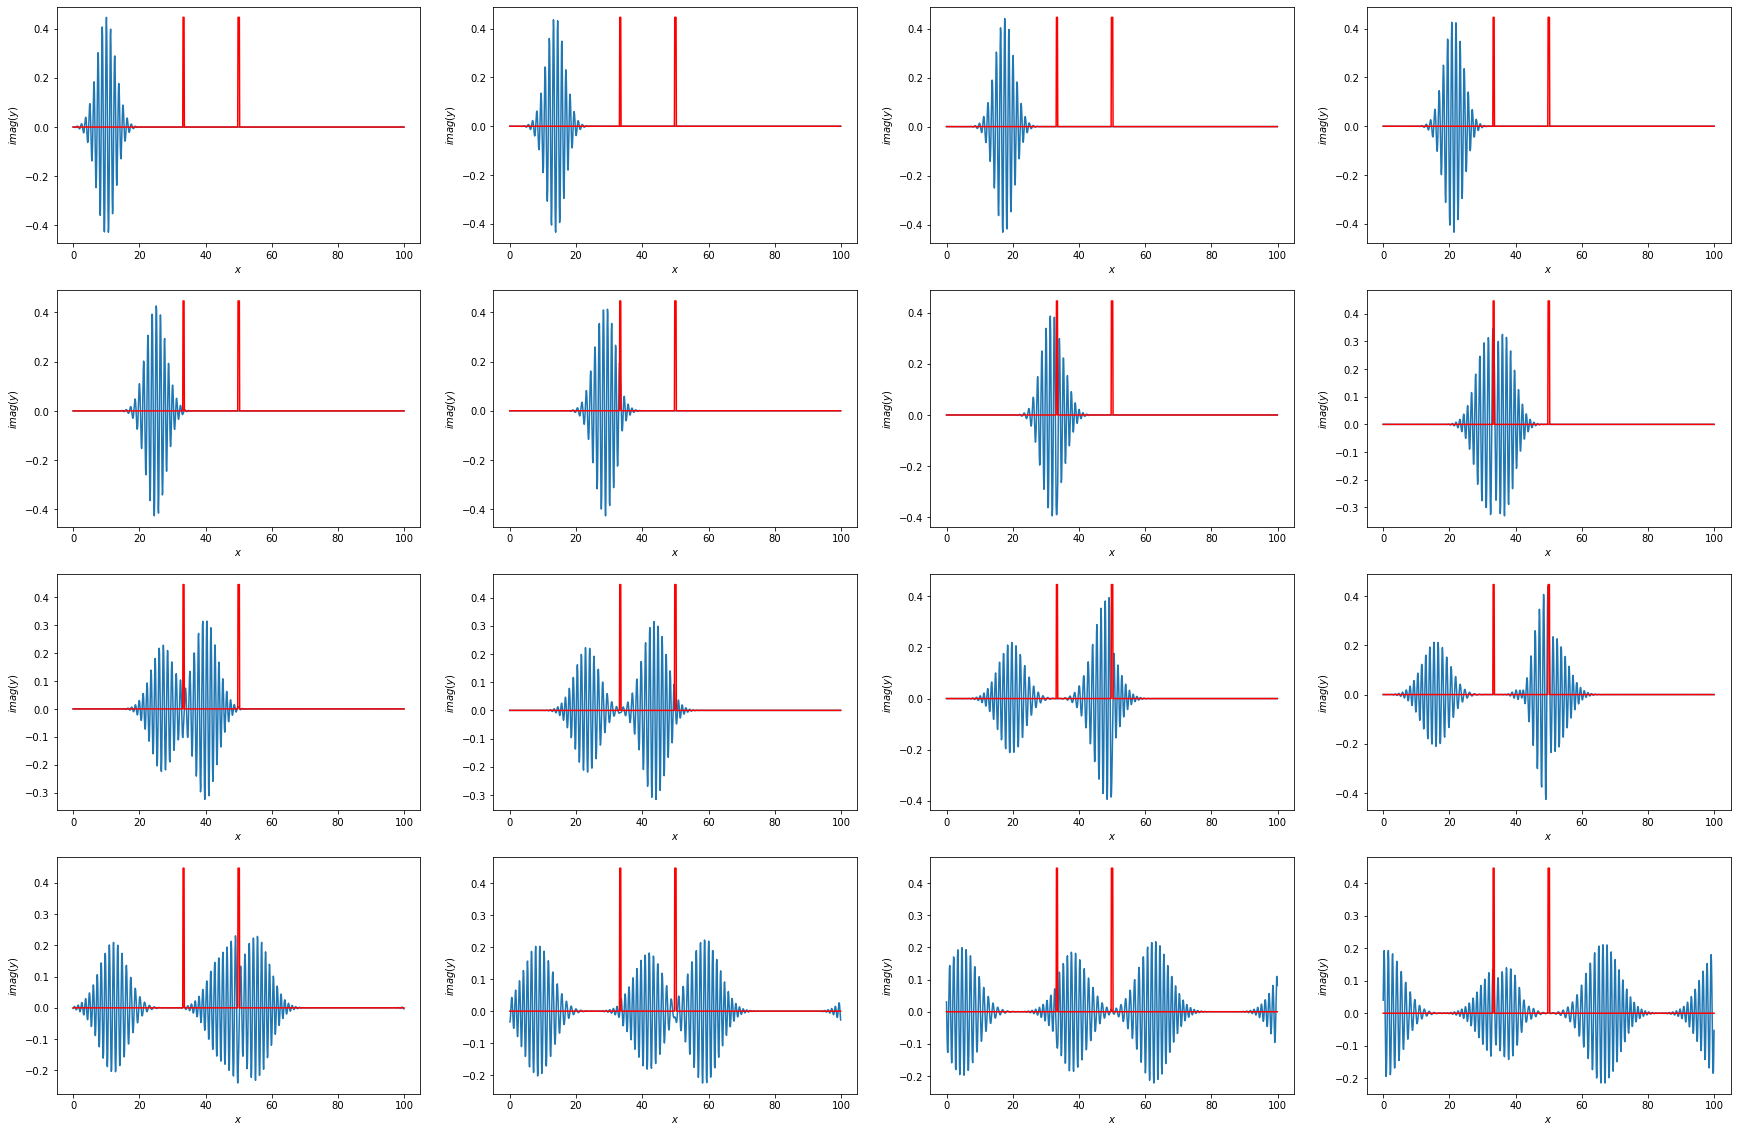

0.00030007326007326006
5.85646653175354


In [3]:
from numpy import sin,cos,fft,linspace,pi,exp,zeros,ones,genfromtxt,savetxt
import matplotlib.pyplot as plt
from time import time



wave2=Wave_packet_dynamics(filename='wave_packet_parameters.txt',fileoutput='storia_y.txt')
time_0=time()
wave2.dynamics()
time2=time()-time_0
wave2.visualizer(item='ystoryreal', labels=True)
print(wave2.dt/wave2.dx)
print(time2)

[1.02400e+03 4.09600e+03 1.00000e+02 1.20000e-01 2.00000e+00 1.00000e+01
 5.00000e+00 4.00000e-01 4.00000e-01 1.00000e+03 1.00000e+03 3.33333e-01
 5.00000e-01]


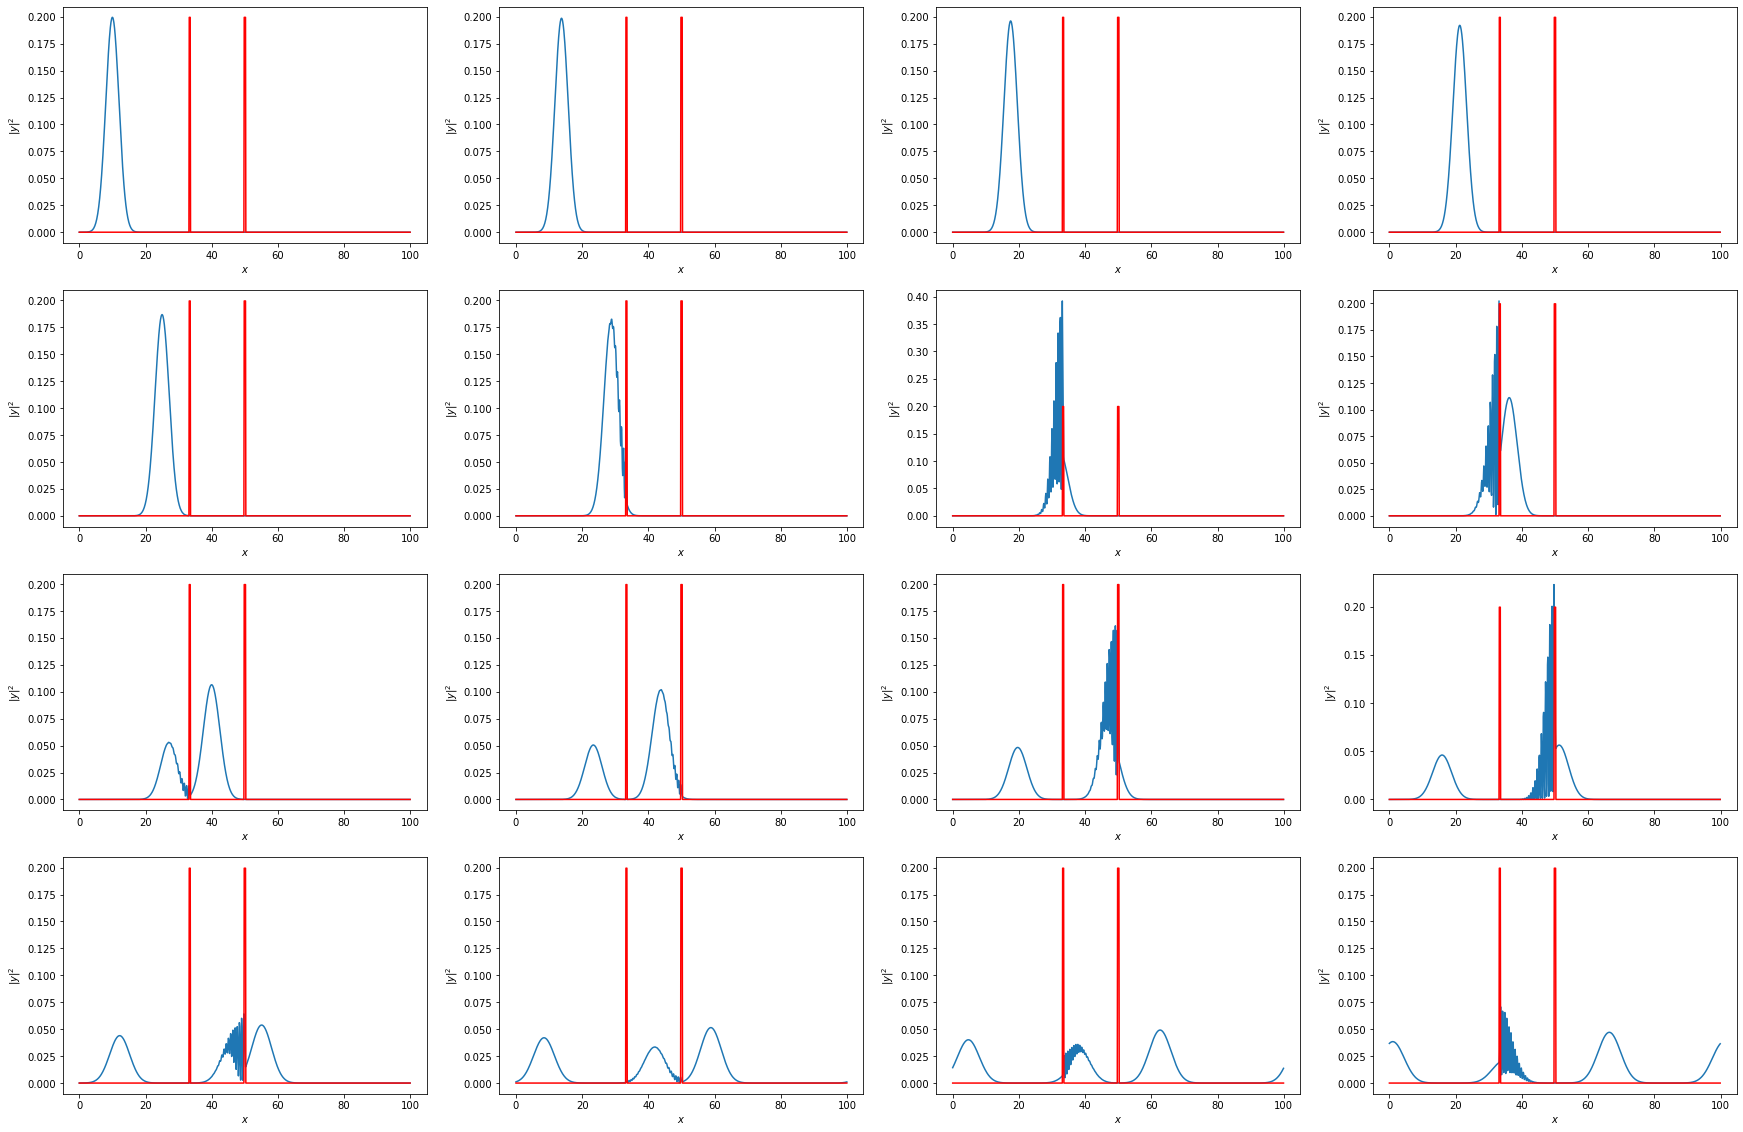

2.0958034992218018


In [4]:
wave=Wave_packet_dynamics(filename='wave_packet_parameters.txt')
time_0=time()
wave.dynamics()
time1=time()-time_0
wave.visualizer()
print(time1)

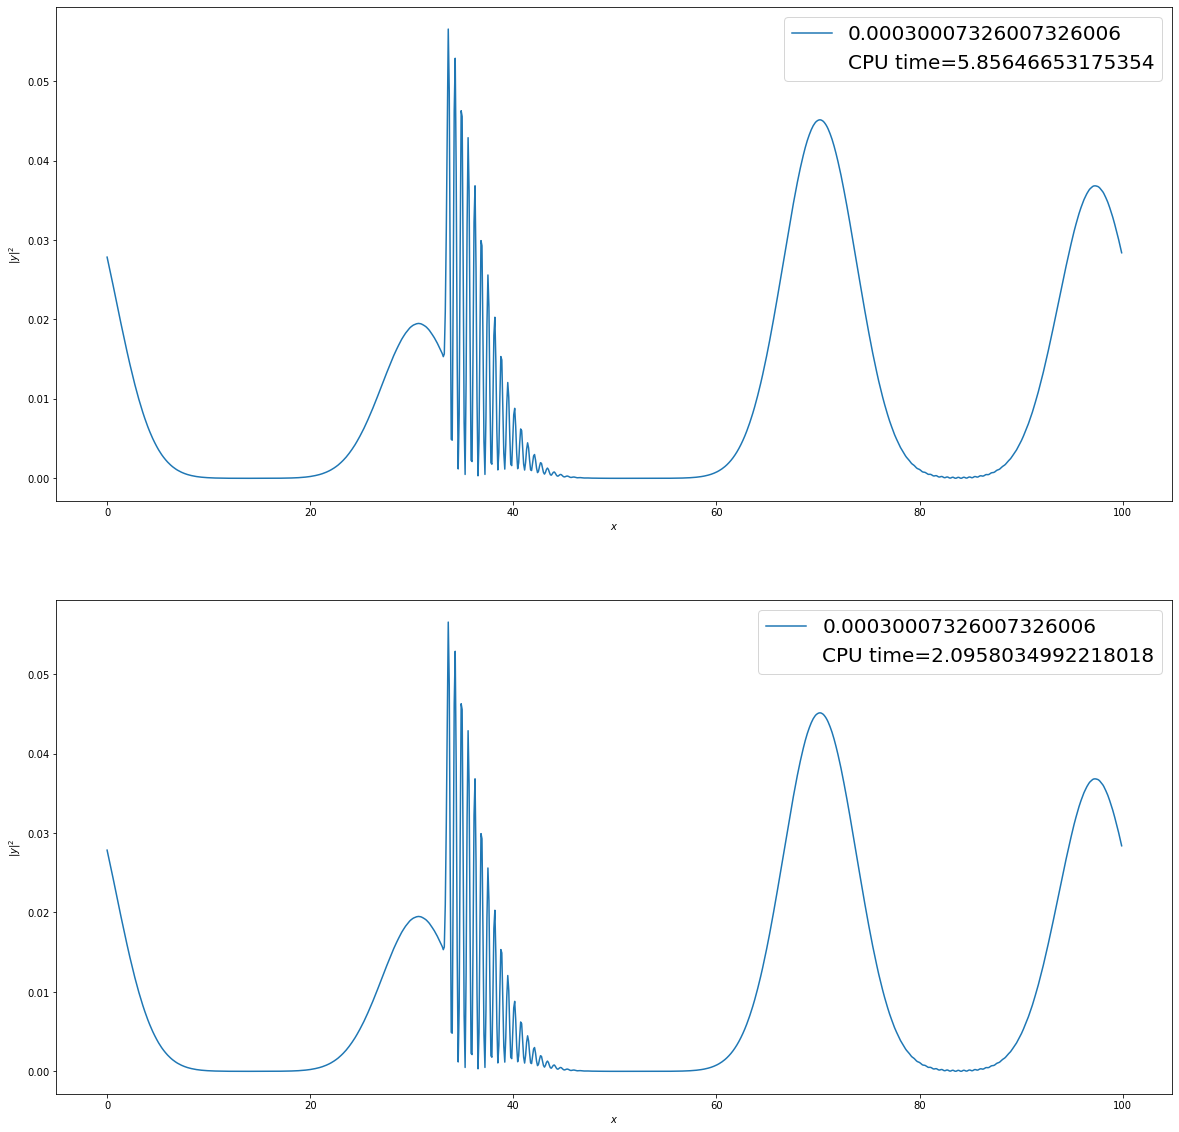

In [5]:
fig,ax=plt.subplots(2,1,figsize=[20,20])
stringa1='CPU time='+str(time1)
stringa2='CPU time='+str(time2)

ax[0].set_ylabel('$\| y \| ^2$')
ax[0].set_xlabel('$x$')
ax[1].set_ylabel('$\| y \| ^2$')
ax[1].set_xlabel('$x$')


ax[0].plot(wave2.x,wave2.ystory[-1],label=wave2.dt/wave2.dx)
ax[0].plot(0,0,linewidth=0.001,label=stringa2)
ax[1].plot(wave.x,wave.ystory[-1],label=wave.dt/wave.dx)
ax[1].plot(0,0,linewidth=0.001,label=stringa1)
ax[0].legend(fontsize=20)
ax[1].legend(fontsize=20)
plt.show()


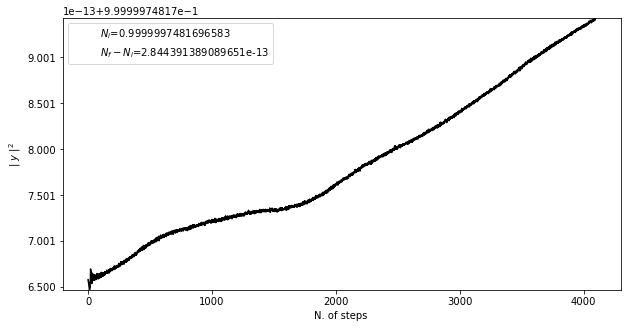

In [6]:
fig,ax=plt.subplots(figsize=[10,5])

n0=wave.normstory[0]
ndiff=wave.normstory[-1]-wave.normstory[0]
stringa='$N_i$='+str(wave.normstory[0])
stringa2='$N_f - N_i$='+str(ndiff)
ax.plot(wave.normstory[:],'k')
ax.plot(wave.normstory[0],linewidth=0.001,label=stringa)
ax.plot(wave.normstory[1],linewidth=0.001,label=stringa2)


ax.set_ylim(min(wave.normstory),max(wave.normstory))
ax.set_ylabel('$\| \ y \ |^2$')
ax.set_xlabel('N. of steps ')
ax.legend()


plt.show()


In [7]:
help(savetxt)

Help on function savetxt in module numpy:

savetxt(fname, X, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ', encoding=None)
    Save an array to a text file.
    
    Parameters
    ----------
    fname : filename or file handle
        If the filename ends in ``.gz``, the file is automatically saved in
        compressed gzip format.  `loadtxt` understands gzipped files
        transparently.
    X : 1D or 2D array_like
        Data to be saved to a text file.
    fmt : str or sequence of strs, optional
        A single format (%10.5f), a sequence of formats, or a
        multi-format string, e.g. 'Iteration %d -- %10.5f', in which
        case `delimiter` is ignored. For complex `X`, the legal options
        for `fmt` are:
    
        * a single specifier, `fmt='%.4e'`, resulting in numbers formatted
          like `' (%s+%sj)' % (fmt, fmt)`
        * a full string specifying every real and imaginary part, e.g.
          `' %.4e %+.4ej %.4e %+.4ej %.4

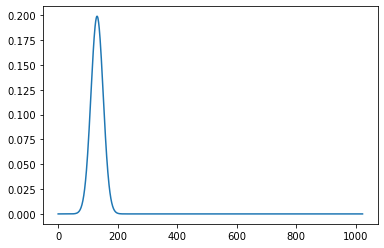

In [8]:
plt.figure()
plt.plot(wave2.ystory[189,:])